<a href="https://colab.research.google.com/github/israt-tabassum/AirQuality_Univariate/blob/main/TSPerceiver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 M

epoch,train_loss,valid_loss,mae,time
0,0.013118,0.002450,0.047571,00:18
1,0.004477,0.001949,0.036620,00:17
2,0.001328,0.000123,0.009432,00:18
3,0.001349,0.002075,0.042642,00:25
4,0.001390,0.000154,0.009841,00:17
5,0.000849,0.000151,0.010797,00:18


No improvement since epoch 2: early stopping


Train MAE: 0.0117
Validation MAE: 0.0108
Test MAE: 0.0108


Validation RMSE: 397618.9742


Predicted next 4 values: [ -1647.9332 773272.1    185581.02    -1647.9332]


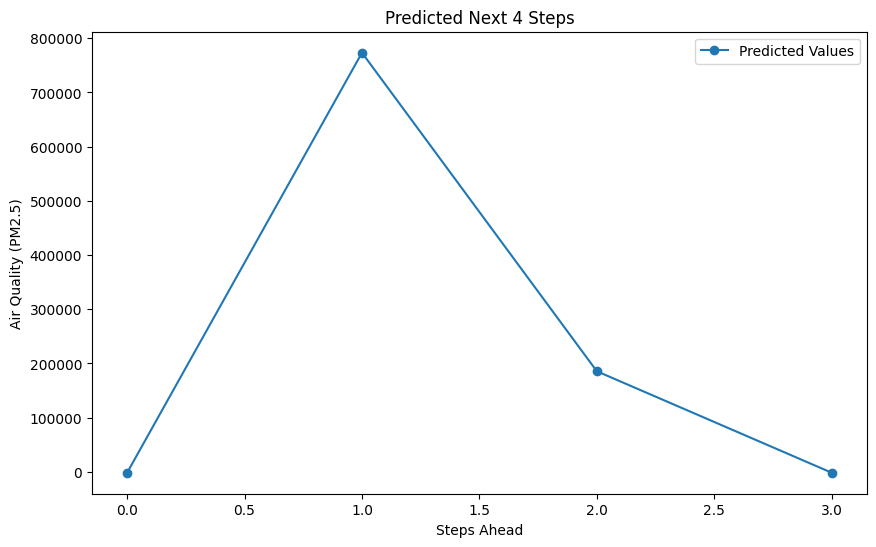

In [ ]:
!pip install tsai
!pip install fastai

import torch
import torch.nn as nn
from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from google.colab import drive
from fastai.callback.tracker import EarlyStoppingCallback

# TSPerceiver Model Definition
class TSPerceiver(nn.Module):
    def __init__(self, c_in, c_out, seq_len, latent_dim=128, n_layers=3, n_heads=8, d_model=256, d_ff=512, dropout=0.1):
        super(TSPerceiver, self).__init__()
        self.latent_dim = latent_dim
        self.latent = nn.Parameter(torch.randn(1, latent_dim, d_model))  # Latent array
        self.input_projection = nn.Linear(c_in, d_model)
        self.position_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.output_projection = nn.Linear(d_model, c_out)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0, 2, 1)  # From (batch_size, c_in, seq_len) -> (batch_size, seq_len, c_in)
        x = self.input_projection(x) + self.position_embedding
        x = x.permute(1, 0, 2)  # From (batch_size, seq_len, d_model) -> (seq_len, batch_size, d_model)
        latent = self.latent.expand(batch_size, -1, -1).permute(1, 0, 2)  # Expand latent across batch
        for layer in self.encoder_layers:
            latent = layer(latent)
        latent = latent.permute(1, 0, 2)  # (batch_size, latent_dim, d_model)
        return self.output_projection(latent[:, -1, :])  # Use last latent representation

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the data
df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start', 'End'])

# Filter and preprocess data
df = df[['Start', 'Value']].sort_values(by='Start')

# Resample the data to 6-hour intervals
df.set_index('Start', inplace=True)
df_resampled = df.resample('6H').mean().reset_index()

# Scale the data
scaler = MinMaxScaler()
df_resampled['Value'] = scaler.fit_transform(df_resampled[['Value']])
values = df_resampled['Value'].values

# Define sequence length and forecast horizon
sequence_length = 4
forecast_steps = 4

# Create time-series dataset using SlidingWindow
X, y = SlidingWindow(window_len=sequence_length, horizon=forecast_steps)(values)

# Split dataset into train/validation/test (80:10:10)
train_size = int(len(X) * 0.8)
valid_size = int(len(X) * 0.1)
splits = (
    list(range(train_size)),
    list(range(train_size, train_size + valid_size)),
    list(range(train_size + valid_size, len(X)))
)

# Convert to DataLoaders for tsai
tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=16)

# Define the TSPerceiver model
model = TSPerceiver(
    c_in=1,        # Number of input features (PM2.5 value)
    c_out=forecast_steps,  # Number of output features
    seq_len=sequence_length,  # Length of the input sequences
    latent_dim=64,  # Latent dimension
    d_model=128,    # Model dimension
    n_heads=8,      # Number of attention heads
    n_layers=3,     # Number of encoder layers
    d_ff=256,       # Dimension of the feed-forward network
    dropout=0.1,    # Dropout rate
)

# Implement EarlyStoppingCallback
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)

# Create a Learner with EarlyStopping
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=mae, cbs=[early_stop_cb])

# Train the model
learn.fit_one_cycle(10, lr_max=1e-3)

# Evaluate train, validation, and test performance
train_mae = learn.validate(ds_idx=0)[1]
valid_mae = learn.validate(ds_idx=1)[1]
test_mae = learn.validate(ds_idx=2)[1]

print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {valid_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Calculate RMSE on validation set
preds, targs = learn.get_preds(ds_idx=1)
y_valid_pred = np.clip(preds.numpy(), 0.0, 1.0)  # Clip predictions
y_valid_true = targs.numpy()
y_valid_pred = scaler.inverse_transform(y_valid_pred)
y_valid_true = scaler.inverse_transform(y_valid_true)
rmse = sqrt(mean_squared_error(y_valid_true.flatten(), y_valid_pred.flatten()))
print(f"Validation RMSE: {rmse:.4f}")

# Predict future steps
last_seq = values[-sequence_length:].reshape(1, sequence_length)
last_seq = torch.tensor(last_seq).unsqueeze(1).float()
preds = learn.get_X_preds(last_seq)[0].numpy()
preds = np.clip(preds, 0.0, 1.0)
preds = scaler.inverse_transform(preds)

# Print predictions
print(f"Predicted next {forecast_steps} values: {preds.flatten()}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps} Steps")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()


Mounted at /content/drive


epoch,train_loss,valid_loss,mae,time
0,0.012973,0.000620,0.020073,01:51
1,0.004670,0.001430,0.034554,01:34
2,0.001999,0.000194,0.011943,01:32
3,0.001355,0.000221,0.012745,01:31
4,0.000923,0.000049,0.005581,01:32
5,0.000993,0.000715,0.024387,01:33
6,0.001349,0.001176,0.026951,01:32
7,0.001015,0.000175,0.012920,01:33


No improvement since epoch 4: early stopping


Train MAE: 0.0008, Train Accuracy: 0.0138
Validation MAE: 0.0002, Validation Accuracy: 0.0129
Test MAE: 0.0002, Test Accuracy: 0.0129


Predicted next 24 hours (4 steps): -1647.93: Good, -1647.93: Good, 761189.25: Severe, 416881.19: Severe


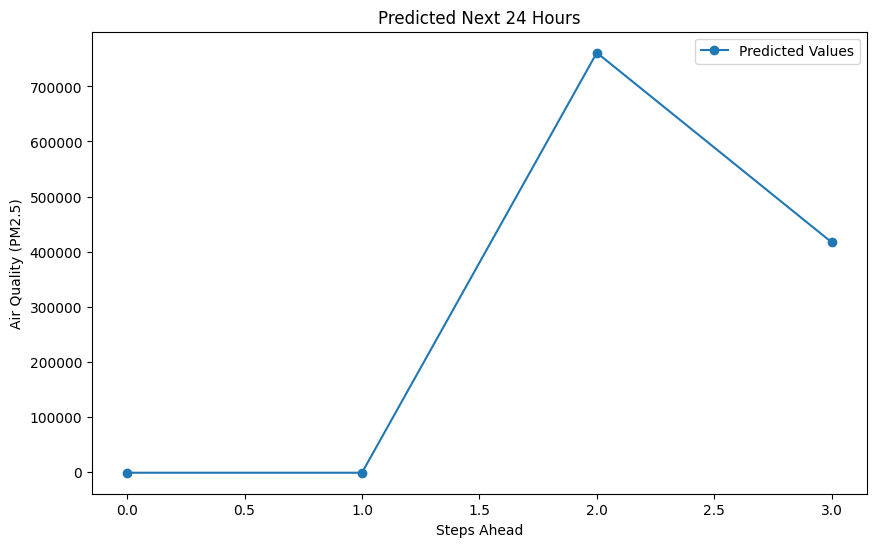

In [ ]:
import torch
import torch.nn as nn
from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from fastai.callback.tracker import EarlyStoppingCallback
from google.colab import drive

class TSPerceiver(nn.Module):
    def __init__(self, c_in, c_out, seq_len, latent_dim=128, n_layers=3, n_heads=8, d_model=256, d_ff=512, dropout=0.1):
        super(TSPerceiver, self).__init__()
        self.latent_dim = latent_dim
        self.latent = nn.Parameter(torch.randn(1, latent_dim, d_model))
        self.input_projection = nn.Linear(c_in, d_model)
        self.position_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.output_projection = nn.Linear(d_model, c_out)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0, 2, 1)
        x = self.input_projection(x) + self.position_embedding
        x = x.permute(1, 0, 2)
        latent = self.latent.expand(batch_size, -1, -1).permute(1, 0, 2)
        for layer in self.encoder_layers:
            latent = layer(latent)
        latent = latent.permute(1, 0, 2)
        return self.output_projection(latent[:, -1, :])

def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

drive.mount('/content/drive', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start'])
df = df[['Start', 'Value']].sort_values(by='Start')
df.set_index('Start', inplace=True)
df['Value'] = df['Value'].astype(float)
df.dropna(subset=['Value'], inplace=True)
df['category'] = df['Value'].apply(get_AQI_bucket)
category_mapping = {'Good': 1, 'Satisfactory': 2, 'Moderate': 3, 'Poor': 4, 'Very Poor': 5, 'Severe': 6}
df['label'] = df['category'].map(category_mapping)
df_resampled = df[['Value']].resample('6H').mean().interpolate()
scaler = MinMaxScaler()
df_resampled['Value'] = scaler.fit_transform(df_resampled[['Value']])
values = df_resampled['Value'].values
sequence_length = 24
forecast_steps = 4
X, y = SlidingWindow(window_len=sequence_length, horizon=forecast_steps)(values)
train_size = int(len(X) * 0.8)
valid_size = int(len(X) * 0.1)
splits = (
    list(range(train_size)),
    list(range(train_size, train_size + valid_size)),
    list(range(train_size + valid_size, len(X)))
)
tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=16)
model = TSPerceiver(
    c_in=1,
    c_out=forecast_steps,
    seq_len=sequence_length,
    latent_dim=128,
    n_layers=3,
    n_heads=8,
    d_model=256,
    d_ff=512,
    dropout=0.1
)
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mae], cbs=[early_stop_cb])
learn.fit_one_cycle(10, lr_max=1e-3)
train_mae, train_acc = learn.validate(ds_idx=0)
valid_mae, valid_acc = learn.validate(ds_idx=1)
test_mae, test_acc = learn.validate(ds_idx=2)
print(f"Train MAE: {train_mae:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation MAE: {valid_mae:.4f}, Validation Accuracy: {valid_acc:.4f}")
print(f"Test MAE: {test_mae:.4f}, Test Accuracy: {test_acc:.4f}")
last_seq = values[-sequence_length:].reshape(1, sequence_length)
last_seq = torch.tensor(last_seq).unsqueeze(1).float()
preds = learn.get_X_preds(last_seq)[0].numpy()
preds = np.clip(preds, 0, 1)
preds = scaler.inverse_transform(preds)
forecast_with_categories = []
for p in preds.flatten():
    category = get_AQI_bucket(p)
    forecast_with_categories.append(f"{p:.2f}: {category}")
print(f"Predicted next {forecast_steps * 6} hours (4 steps): {', '.join(forecast_with_categories)}")
plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps * 6} Hours")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()
